### Import libraries

In [43]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from IPython.display import HTML, display, SVG
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot

import math
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.grid_search import GridSearchCV
import xgboost
import lightgbm

import nltk
import string
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

In [3]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

In [4]:
def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:]
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

In [5]:
seed = 13
stemmer = SnowballStemmer("english")
lemma = WordNetLemmatizer()

le = LabelEncoder()

In [6]:
SOURCE_FOLDER = 'dataset/'
OUTPUT_FOLDER = 'Models_and_output/'

In [7]:
train_data = pd.read_csv(SOURCE_FOLDER + 'train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv(SOURCE_FOLDER + 'test.csv', encoding='utf8')
test_data = test_data[test_data.columns[1:-1]]

In [8]:
train_data.head(30)

Source                                              Host  \
0   FORUMS                                    cafepharma.com   
1   FORUMS                                 www.patient.co.uk   
2     BLOG  http://abcnewsradioonline.com/entertainment-news   
3   FORUMS                             www.cancer-forums.net   
4   FORUMS                                  www.diyaudio.com   
5   FORUMS                               forum.cyclinguk.org   
6   FORUMS                                    www.reddit.com   
7     BLOG                   http://quranfruitz.blogspot.com   
8   FORUMS                                        hmnews.org   
9   FORUMS                                www.cafepharma.com   
10  FORUMS                                   modelmayhem.com   
11  FORUMS                           blueheronhealthnews.com   
12    BLOG     http://medicaldevicemarkettrends.blogspot.com   
13    BLOG                  http://www.becomerichfaster.com/   
14  FORUMS                                      www.fark.com   
15    BLOG                            http://news.health.com   
16  FORUMS                                 finance.yahoo.com   
17    BLOG                           http://wwj.cbslocal.com   
18  FORUMS                      guboards.spokesmanreview.com   
19    BLOG                      http://mostdiet.blogspot.com   
20    BLOG         http://eliteathletictraining.blogspot.com   
21  FORUMS                                    alkpathway.com   
22  FORUMS                             www.explorerforum.com   
23  FORUMS                         stltommorow.proboards.com   
24    BLOG                         http://www.4-traders.com/   
25    BLOG                              feedproxy.google.com   
26    BLOG               http://befitweightloss.blogspot.com   
27    BLOG                              http://drkelley.info   
28  FORUMS                                www.xboxhacker.org   
29    BLOG               http://dangchuatinhcon.blogspot.com   

                                                 Link   Date(ET)     Time(ET)  \
0   http://cafepharma.com/boards/threads/epstein.5...  6/15/2016     13:58:00   
1   http://www.patient.co.uk/forums/discuss/enlarg...   5/7/2016  0.820833333   
2   http://abcnewsradioonline.com/entertainment-ne...  4/14/2016     15:00:38   
3   http://www.cancer-forums.net/viewtopic.php?f=1...  6/18/2016     20:46:00   
4   http://www.diyaudio.com/forums/lounge/292252-d...  6/15/2016      3:26:00   
5   http://forum.cyclinguk.org/viewtopic.php?f=24&...   4/6/2016      5:50:00   
6   https://www.reddit.com/r/todayilearned/comment...   5/2/2016  0.047916667   
7   http://quranfruitz.blogspot.com/2016/02/causes...  2/28/2016      3:20:00   
8   http://hmnews.org/health-care-news/cluster8641...  6/15/2016     17:16:00   
9   http://www.cafepharma.com/boards/threads/nomin...  4/29/2016     23:46:00   
10  http://www.modelmayhem.com/forums/post/960268/...  7/15/2016     15:49:00   
11  http://blueheronhealthnews.com/site/2016/02/22...  2/22/2016     18:52:00   
12  http://medicaldevicemarkettrends.blogspot.com/...  4/26/2016      5:48:00   
13  http://www.becomerichfaster.com/money-morning/...  3/18/2016     19:00:28   
14  http://www.fark.com/comments/9116353/Now-is-wh...  4/21/2016     10:17:00   
15  http://news.health.com/2016/03/28/do-it-yourse...  3/28/2016     15:37:07   
16  http://finance.yahoo.com/mbview/threadview/?&b...  6/17/2016      5:24:00   
17  http://detroit.cbslocal.com/2016/03/06/former-...   3/6/2016     12:45:51   
18  http://guboards.spokesmanreview.com/showthread...  7/25/2016     10:42:00   
19  http://mostdiet.blogspot.com/2016/04/pot-belly...   4/3/2016      3:18:00   
20  http://eliteathletictraining.blogspot.com/2016...  6/21/2016     16:08:00   
21    http://alkpathway.com/50-cytokines-tnf-il1-il6/  4/26/2016     22:51:00   
22  http://www.explorerforum.com/forums/showthread...   4/7/2016     21:47:00   
23  http://stltommorow.proboards.com/thread/8090/l...  6/20/2016     12:40:

In [9]:
train_data = train_data[train_data['TRANS_CONV_TEXT'].notnull()]

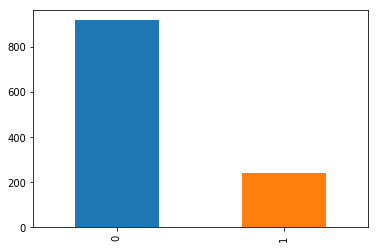

In [10]:
le.fit(train_data.Source)
train_source = le.transform(train_data.Source)

train_data.Patient_Tag.value_counts().plot('bar')

In [11]:
X_train = train_data['TRANS_CONV_TEXT']
Y_train = train_data['Patient_Tag']
Y_train = to_categorical(Y_train)

In [12]:
def preprocess_data(X_train, stemmer, lemma):
    preprocessed_data = []
    trans = str.maketrans('/(){}', ' ' * 5)
    trans_punc = str.maketrans('', '', string.punctuation)

    for text in X_train:
        text = text.lower().translate(trans)
        text = text.translate(trans_punc)
        text = [lemma.lemmatize(word) for word in text.split()]
        preprocessed_data.append(' '.join(text))

    return preprocessed_data

In [13]:
preprocessed_data = preprocess_data(X_train, stemmer, lemma)

In [14]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english', ngram_range=(1, 3))
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [15]:
X_train = vectorizer.transform(X_train).toarray()
X_train.shape

(1156, 1000)

In [16]:
X_train = np.insert(X_train, 0, train_source, axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.33, random_state=seed)

In [17]:
train_data.Source.head()

0    FORUMS
1    FORUMS
2      BLOG
3    FORUMS
4    FORUMS
Name: Source, dtype: object

In [18]:
X_train.shape

(774, 1001)

In [19]:
X_valid.shape

(382, 1001)

In [49]:
params={
    'max_depth': [3,5,7,9,15], # 5 is good but takes too long in kaggle env
    'subsample': [0.4,0.6,0.8,1.0],
    'colsample_bytree': [0.5,0.7,0.9],
    'n_estimators': [800], #[1000,2000,3000]
    'reg_alpha': [0.01, 0.05, 0.1]
}

xgb_clf = xgboost.XGBClassifier(eval_set=[(X_valid, y_valid[:,1])])
rs = GridSearchCV(xgb_clf,
                  params,
                  cv=5,
                  scoring="log_loss",
                  n_jobs=1,
                  verbose=2)

In [50]:
rs.fit(X_train, y_train[:,1])

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.2s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.1s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.1s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.1s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.3s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.4s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=

[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.4s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.4s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.4s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.4s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.5 -   6.3s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=3, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=3, colsampl

[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=5, colsample_bytree=0.5 -   9.1s
[CV] reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 -   8.6s
[CV] reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 -  10.3s
[CV] reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 -  10.1s
[CV] reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 -  10.7s
[CV] reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=

[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=7, colsample_bytree=0.5 -  10.7s
[CV] reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 -  10.3s
[CV] reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 -  11.6s
[CV] reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 -  10.8s
[CV] reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 -  10.6s
[CV] reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=

[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.5 -  10.6s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 -   9.7s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 -   9.7s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 -   9.8s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 -   9.7s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=9

[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 -   9.6s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.5 -   9.2s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=9, colsample_bytree=0.5 -  11.0s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=9, colsample_bytree=0.5 -  11.8s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=9, colsample_bytree=0.5 -  11.5s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=9, colsample_bytree=0.5 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=9, colsampl

[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.5 -  12.1s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.5 -  11.5s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.5 -  11.0s
[CV] reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.5 -  10.8s
[CV] reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.5 -  10.8s
[CV] reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.5 
[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, 

[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   7.6s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   7.6s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   7.6s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   7.7s
[CV] reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   6.4s
[CV] reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=

[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   6.5s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   6.6s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   6.8s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   7.2s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=3, colsample_bytree=0.7 -   6.6s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=5, colsam

[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=5, colsample_bytree=0.7 -  11.6s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 -  12.1s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 -  11.8s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 -  12.1s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 -  12.0s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=5, colsamp

[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=7, colsample_bytree=0.7 -  13.6s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 -  14.2s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 -  15.0s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 -  15.4s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 -  15.2s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=7, colsample_bytree=0.7 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=

[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  14.8s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  15.1s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  15.6s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  15.7s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  15.7s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=

[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  15.8s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  16.2s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  14.7s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  15.5s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=9, colsample_bytree=0.7 -  16.1s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=9, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=9, colsampl

[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=15, colsample_bytree=0.7 -  15.5s
[CV] reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=15, colsample_bytree=0.7 
[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=15, colsample_bytree=0.7 -  15.7s
[CV] reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=15, colsample_bytree=0.7 
[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=15, colsample_bytree=0.7 -  16.0s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=15, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=15, colsample_bytree=0.7 -  12.8s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=15, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=15, colsample_bytree=0.7 -  12.4s
[CV] reg_alpha=0.1, subsample=0.4, n_estimators=800, max_depth=15, colsample_bytree=0.7 
[CV]  reg_alpha=0.1, subsample=0.4, n_estimators=800, max_de

[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.9 -  10.1s
[CV] reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.9 -  10.1s
[CV] reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.9 -  10.1s
[CV] reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=3, colsample_bytree=0.9 -  10.1s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.9 -  10.7s
[CV] reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=3, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.6, n_estimators=800, max_depth=

[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  17.0s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  18.0s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  16.8s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  16.4s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  16.7s
[CV] reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.8, n_estimators=800, max_depth=

[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  16.3s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  16.6s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  16.4s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  16.4s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=5, colsample_bytree=0.9 -  16.2s
[CV] reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=5, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=1.0, n_estimators=800, max_depth=5, colsampl

[CV]  reg_alpha=0.05, subsample=0.8, n_estimators=800, max_depth=7, colsample_bytree=0.9 -  18.2s
[CV] reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 -  18.3s
[CV] reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 -  18.8s
[CV] reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 -  18.9s
[CV] reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 -  19.1s
[CV] reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=7, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=1.0, n_estimators=800, max_depth=

[CV]  reg_alpha=0.01, subsample=1.0, n_estimators=800, max_depth=9, colsample_bytree=0.9 -  17.4s
[CV] reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 -  15.2s
[CV] reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 -  15.2s
[CV] reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 -  15.4s
[CV] reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 -  15.4s
[CV] reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=9, colsample_bytree=0.9 
[CV]  reg_alpha=0.05, subsample=0.4, n_estimators=800, max_depth=

[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  17.3s
[CV] reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.4, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  17.5s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  21.9s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  21.8s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  19.9s
[CV] reg_alpha=0.01, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.01, subsample=0.6, n_estimators=800, 

[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  19.6s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  18.8s
[CV] reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.6, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  18.4s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  19.2s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.9 -  19.2s
[CV] reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=15, colsample_bytree=0.9 
[CV]  reg_alpha=0.1, subsample=0.8, n_estimators=800, max_depth=1

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 192.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1,
       eval_set=[(array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [3., 0., ..., 0., 0.],
       [2., 0., ..., 0., 0.]]), array([0., 0., ..., 1., 0.], dtype=float32...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reg_alpha': [0.01, 0.05, 0.1], 'subsample': [0.4, 0.6, 0.8, 1.0], 'n_estimators': [800], 'max_depth': [3, 5, 7, 9, 15], 'colsample_bytree': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=2)

In [ ]:
best_est = rs.best_estimator_

In [51]:
# xgb = xgboost.XGBClassifier(n_estimators=1500, learning_rate=0.05, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=15)
# model_xgboost = xgb.fit(X_train, y_train[:,1], eval_set=[(X_valid, y_valid[:,1])])

In [37]:
# y_train_pred = model_xgboost.predict(X_train)
# Accuracy = accuracy_score(y_train, y_train_pred) * 100
# F1_score = f1_score(y_train, y_train_pred, average='weighted')

In [ ]:
# custom_adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

# model = Sequential()
# model.add(Dense(128, activation='relu', input_dim=1001))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(2,
#                 activation='softmax',
#                 kernel_regularizer=L1L2(l1=0.0, l2=0.4)))

In [ ]:
# precision = as_keras_metric(tf.metrics.precision)
# recall = as_keras_metric(tf.metrics.recall)

# model.compile(optimizer=custom_adam,
#               loss='categorical_crossentropy',
#               metrics=[auc_pr, 'accuracy'])

# model.fit_generator(generator=batch_generator_shuffle(X_train, y_train, 32),
#                       epochs=200, validation_data=(X_valid, y_valid),
#                       steps_per_epoch=X_train.shape[0] / 32)

# scores = model.evaluate(X_valid, y_valid)
# print ('\n')
# print (scores)

- 1 - 7: val_loss: 0.3521 - val_auc_pr: 0.9775 - val_acc: 0.8922
- 2 - 200: val_loss: 0.6366 - val_auc_pr: 0.9851 - val_acc: 0.8889
- 3 - val_loss: 1.3443 - val_auc_pr: 0.9714 - val_acc: 0.8246

- [0.626494295846403, 0.983139782170065, 0.8856209134743884]

In [38]:
X_test = test_data['TRANS_CONV_TEXT']
X_test = preprocess_data(X_test, stemmer, lemma)
X_test = vectorizer.transform(X_test).toarray()

test_source = le.transform(test_data.Source)
X_test = np.insert(X_test, 0, test_source, axis=1)

In [39]:
X_test.shape

(571, 1001)

In [40]:
output = model_xgboost.predict(X_test, 32)

# patient_tag = np.argmax(output, axis=1)
patient_tag = output
index = list(range(1, len(output)+1))
test_data_df = pd.DataFrame({'Index': index,'Patient_Tag': patient_tag}).set_index('Index')
test_data_df.Patient_Tag = test_data_df.Patient_Tag.astype('int')
test_data_df.to_csv('output.csv', columns=['Patient_Tag'] )

In [41]:
test_data_df.Patient_Tag.value_counts()

0    508
1     63
Name: Patient_Tag, dtype: int64

In [32]:
# model_json = model.to_json()
# with open(OUTPUT_FOLDER + "3_model.json", "w") as json_file:
#     json_file.write(model_json)

# model.save_weights(OUTPUT_FOLDER + "3_model.h5")

In [ ]:
out = pd.read_csv('Models_and_output/1_output_84_06305.csv')
out.Patient_Tag.value_counts()